# Lab 07

Nagrano słowo mama z wydłużonym pierwszym "a". Wycięto samogłoskę za pomocą programu audacity.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.io import wavfile
from scipy import signal

import warnings
warnings.filterwarnings('ignore')

## Wczytanie pliku dźwiękowego

In [3]:
y, sr = librosa.load("./data/a1.wav", mono=True)
#y = sound.astype('float32')

## Spektogram sygnału

In [4]:
def spectogram(y, title):
    D = librosa.stft(y)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots(figsize=(10, 10))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
    ax.set(title=title)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    return S_db

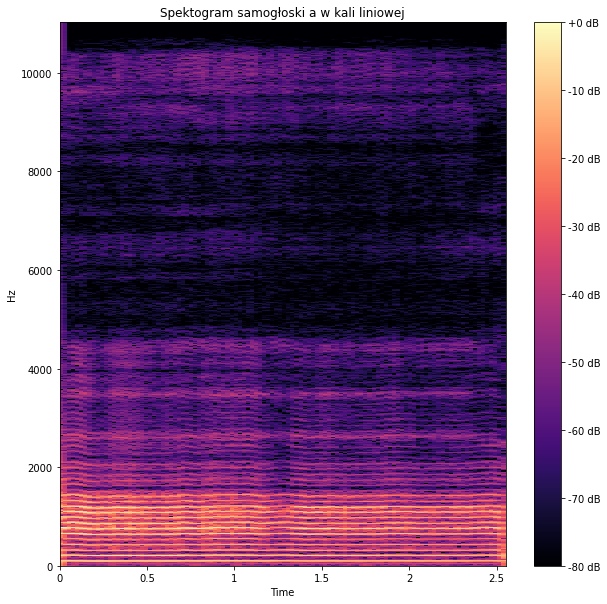

In [5]:
spec_a = spectogram(y, "Spektogram samogłoski a w kali liniowej")

## Wykres w wycinku czasowym

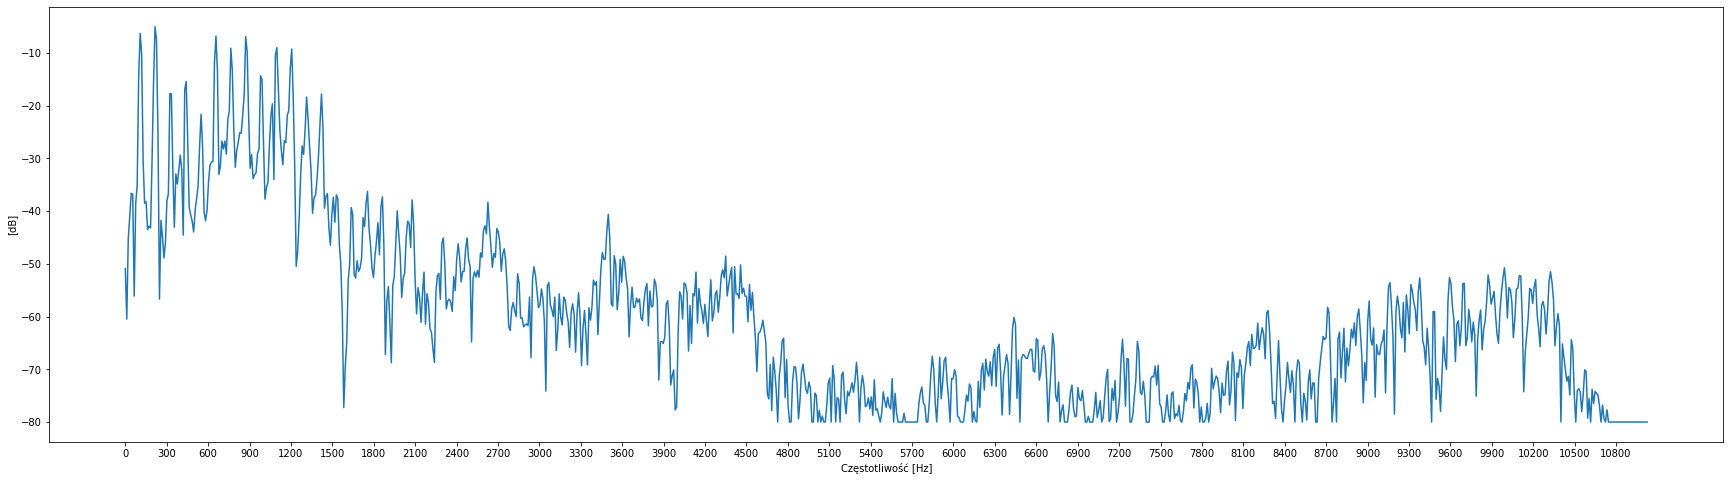

In [6]:
frequencies = librosa.fft_frequencies(sr=22050, n_fft=2048)
fig = plt.figure(figsize=(30, 8))
plt.plot(frequencies, spec_a[:, 20])
plt.xlabel("Częstotliwość [Hz]")
plt.ylabel("[dB]")
_ = plt.xticks(np.arange(0, frequencies[-1], step=300))

## Częstotliwość fundamentalna

https://librosa.org/doc/main/generated/librosa.pyin.html

In [7]:
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0)

### Częstotliwość fundamentalna na spektogramie

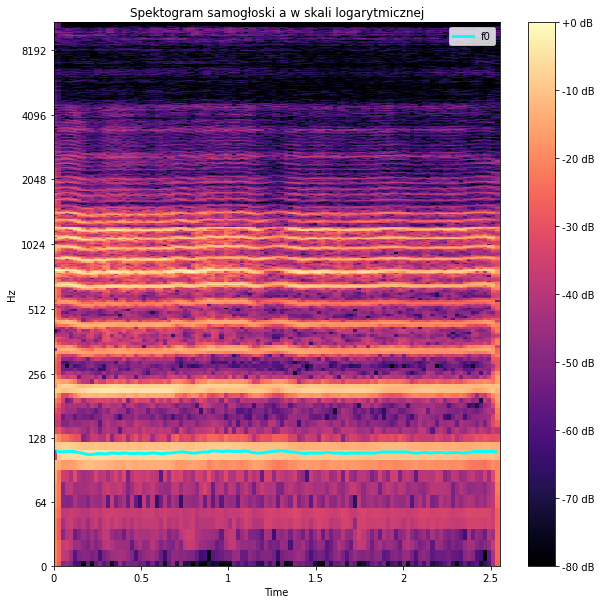

In [8]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots(figsize=(10, 10))
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Spektogram samogłoski a w skali logarytmicznej')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

In [9]:
fundamental_frequency = np.nanmean(f0)
print("Częstotliwość fundamentalna na całym sygnale:", fundamental_frequency)

Częstotliwość fundamentalna na całym sygnale: 110.01029285687771


## Formanty

Należało odczytać 3 formanty. Powinny być to kolejno około 700, 1000, 2000.

https://www.wikiwand.com/en/Formant

https://stackoverflow.com/questions/25107806/estimate-formants-using-lpc-in-python

https://stackoverflow.com/questions/50428617/substitution-of-lpc-in-python-to-estimate-formants-frequency

### Widmo sygnału
https://librosa.org/doc/0.7.0/generated/librosa.onset.onset_strength.html

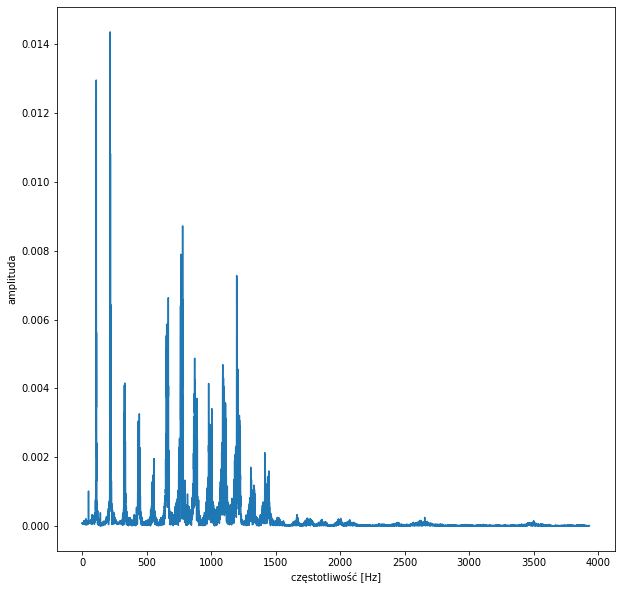

In [10]:
def plot_widmo(y, fs, title):
    widmo_amp = np.abs(np.fft.rfft(y) / (len(y)//2))
    f = np.fft.rfftfreq(len(y), 1/fs)
    plt.plot(f[:10000], widmo_amp[:10000])
    plt.xlabel('częstotliwość [Hz]')
    plt.ylabel('amplituda')
#     plt.ylim([-300, 0])
    plt.title(title)
    plt.show()

plt.figure(figsize=(10, 10))
plot_widmo(y, sr, "")

### Podejście z LPC - niepoprawnie wyznaczone formanty

Próba wyznaczenia formantów z nagranego sygnału za pomocą LPC

https://stackoverflow.com/questions/61519826/how-to-decide-filter-order-in-linear-prediction-coefficients-lpc-while-calcu

In [11]:
import numpy as np
import librosa

A = librosa.core.lpc(y, 12)
rts = np.roots(A)
rts = rts[np.imag(rts) >= 0]
angz = np.arctan2(np.imag(rts), np.real(rts))
frqs = angz * (sr*2) / (2 *  np.pi)
frqs.sort()

In [12]:
frqs

array([    0.    ,   808.0363,  2193.5984,  7950.949 , 14560.737 ,
       19611.732 , 22050.    ], dtype=float32)

### Podejście z formantfeatures - niepoprawnie wyznaczone formanty

Próba wyznaczenia formantów przy użyciu biblioteki formantfeatures.

Warning! Frame size overflow, Size: 506 Limit: 500
formants_features max_frames: 500  features count: 12 frame_count 499
Formant 0 Mean freq: 1157.5751503006013
Formant 0 Mean power: 647.815631262525
Formant 0 Mean width: 60.51102204408818
Formant 0 Mean dissonance: 21.382765531062123
Formant 1 Mean freq: 541.2665330661323
Formant 1 Mean power: 313.19639278557116
Formant 1 Mean width: 37.89178356713427
Formant 1 Mean dissonance: 5.841683366733467
Formant 2 Mean freq: 210.04809619238478
Formant 2 Mean power: 118.39078156312625
Formant 2 Mean width: 12.889779559118237
Formant 2 Mean dissonance: 1.1983967935871744


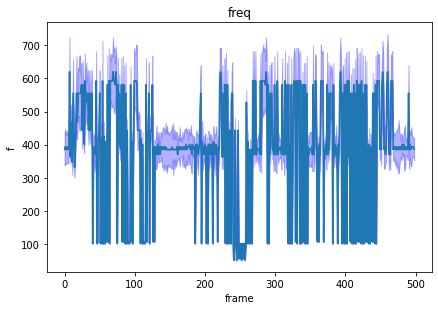

In [13]:
import numpy as np
import formantfeatures as ff
import matplotlib.pyplot as plt


test_wav = "data/a1.wav" #A sample from RAVDESS

window_length = 0.025   #Keep it such that its easier to differentiate syllables and remove pauses
window_step = 0.010
emphasize_ratio = 0.65
f0_min = 30
f0_max = 4000
max_frames = 500
max_formants = 3

formants_features, frame_count, signal_length, trimmed_length = ff.Extract_wav_file_formants(test_wav, window_length, window_step, emphasize_ratio, norm=0, f0_min=f0_min, f0_max=f0_max, max_frames=max_frames, formants=max_formants)

print("formants_features max_frames:", formants_features.shape[0], " features count:", formants_features.shape[1], "frame_count", frame_count)

for formant in range(max_formants):
    print("Formant", formant, "Mean freq:", np.mean(formants_features[0:frame_count, (formant*4)+0]))
    print("Formant", formant, "Mean power:", np.mean(formants_features[0:frame_count, (formant*4)+1]))
    print("Formant", formant, "Mean width:", np.mean(formants_features[0:frame_count, (formant*4)+2]))
    print("Formant", formant, "Mean dissonance:", np.mean(formants_features[0:frame_count, (formant*4)+3]))


x_axis_i = [*range(0, frame_count, 1)]

colors = ['b', 'r', 'g']

for formant in range(0, 1):
    formant_decay_rate = 0.5**(formant)

    log_scaled_freq = formants_features[0:frame_count, formant*4]

    Hz_freq = np.exp(log_scaled_freq / (200*formant_decay_rate))

    Hz_width  = np.exp(np.log(Hz_freq) - formants_features[0:frame_count, (formant*4)+2] / (50 * formant_decay_rate))/4

    width_dn = Hz_freq - Hz_width
    width_up = Hz_freq + Hz_width

    plt.plot(x_axis_i, Hz_freq)
    plt.fill_between(x_axis_i, Hz_freq, width_dn, color=colors[formant], alpha=0.30)
    plt.fill_between(x_axis_i, Hz_freq, width_up, color=colors[formant], alpha=0.30)


plt.tight_layout()
plt.xlabel("frame")
plt.ylabel("f")
plt.title("freq")


plt.show()

## Syntezator Klatta

Jako, że nie udało się poprawnie wyznaczyć formantów, do syntezatora klatta wykorzystam częstotliwości dostarczone w instrukcji laboratorium.

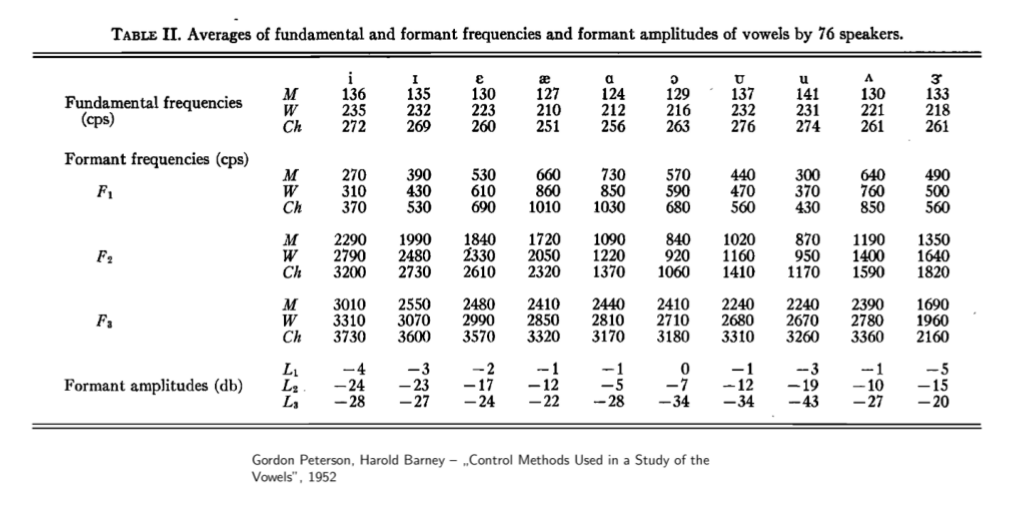

## guestdaniel/tdklatt

Na początku wykorzystano implementację rezonatora Klatta dostępną w repozytorium:
https://github.com/guestdaniel/tdklatt w celu przetestowania działania syntezatora

In [14]:
import tdklatt

In [40]:
s = tdklatt.klatt_make() # Creates a Klatt synthesizer w/ default settings
s.run()

In [41]:
s.play()

In [42]:
s.params

{'F0': array([100., 100., 100., ..., 100., 100., 100.]),
 'AV': array([60., 60., 60., ..., 60., 60., 60.]),
 'OQ': None,
 'SQ': None,
 'TL': None,
 'FL': None,
 'DI': None,
 'AVS': array([0., 0., 0., ..., 0., 0., 0.]),
 'AF': array([0., 0., 0., ..., 0., 0., 0.]),
 'AH': array([0., 0., 0., ..., 0., 0., 0.]),
 'FF': [array([500., 500., 500., ..., 500., 500., 500.]),
  array([1500., 1500., 1500., ..., 1500., 1500., 1500.]),
  array([2500., 2500., 2500., ..., 2500., 2500., 2500.]),
  array([3500., 3500., 3500., ..., 3500., 3500., 3500.]),
  array([4500., 4500., 4500., ..., 4500., 4500., 4500.])],
 'BW': [array([50., 50., 50., ..., 50., 50., 50.]),
  array([100., 100., 100., ..., 100., 100., 100.]),
  array([100., 100., 100., ..., 100., 100., 100.]),
  array([200., 200., 200., ..., 200., 200., 200.]),
  array([250., 250., 250., ..., 250., 250., 250.])],
 'FGP': array([0., 0., 0., ..., 0., 0., 0.]),
 'BGP': array([100., 100., 100., ..., 100., 100., 100.]),
 'FGZ': array([1500., 1500., 1500.,

### Samogłoska "a"

In [72]:
s.params["F0"] = np.ones(s.params["N_SAMP"])*110 # Change F0 to steady-state 200 Hz
formants = [np.ones(s.params["N_SAMP"])*730, np.ones(s.params["N_SAMP"])*1090, np.ones(s.params["N_SAMP"])*2440,  np.ones(s.params["N_SAMP"])*3500,  np.ones(s.params["N_SAMP"])*4500]
s.params["FF"] = formants

In [73]:
s.run()
s.play()

In [74]:
wavfile.write(f"./data/a_synth.wav", 16000, y)

### Samogłoska "i"

In [75]:
s.params["F0"] = np.ones(s.params["N_SAMP"])*110 # Change F0 to steady-state 200 Hz
formants = [np.ones(s.params["N_SAMP"])*270, np.ones(s.params["N_SAMP"])*2300, np.ones(s.params["N_SAMP"])*3000,  np.ones(s.params["N_SAMP"])*3500,  np.ones(s.params["N_SAMP"])*4500]
s.params["FF"] = formants

In [76]:
s.run()
s.play()

In [77]:
wavfile.write(f"./data/i_synth.wav", 16000, y)

### Samogłoska "o"

In [78]:
s.params["F0"] = np.ones(s.params["N_SAMP"])*110 # Change F0 to steady-state 200 Hz
formants = [np.ones(s.params["N_SAMP"])*500, np.ones(s.params["N_SAMP"])*800, np.ones(s.params["N_SAMP"])*2500,  np.ones(s.params["N_SAMP"])*3500,  np.ones(s.params["N_SAMP"])*4500]
s.params["FF"] = formants

In [82]:
s.run()
s.play()

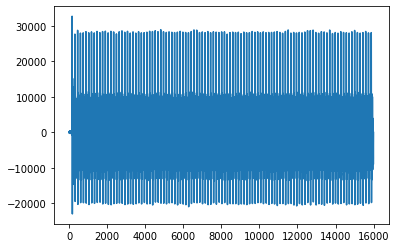

In [80]:
y = s._get_int16at16K()
plt.plot(y)

In [81]:
wavfile.write(f"./data/o_synth.wav", 16000, y)

### Wnioski

Generowane samogłoski na podstawie podanych częstotliwości fundamentalnych i formantów rzeczywiście generowane są w sposób zrozumiały. Z łatwością można powiedzieć, że nie jest to dźwięk naturalny, bo brzmi "metalicznie".

## Własna implementacja syntezatora Klatta

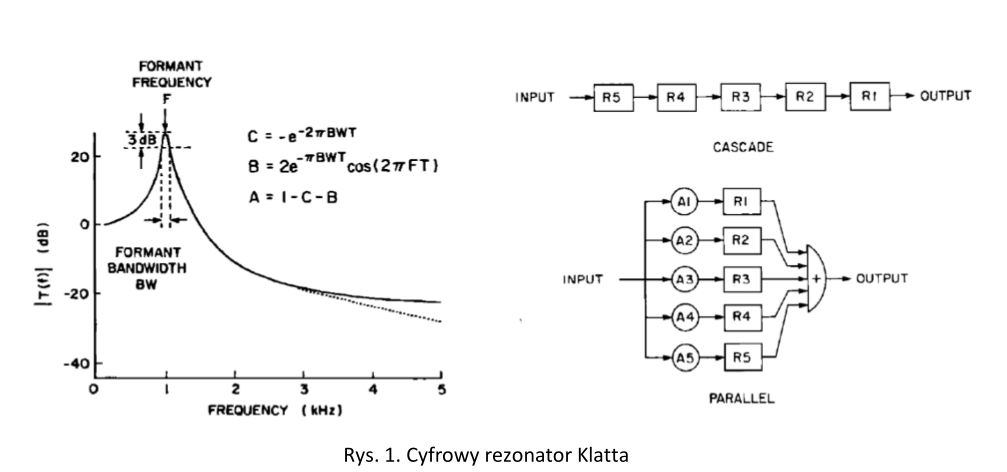

Cyfrowy rezonator Klatta opisany jest przez równanie różnicowe drugiego rzędu posiadający odpowiedź częstotliwościową opisaną zależnością:

$$
H(z)=\frac{A}{1-B z^{-1}-C z^{-2}}
$$

gdzie:

$C=-e^{-2 \pi \cdot B W \cdot T}$

$B=2 e^{-\pi \cdot B W \cdot T} \cos (2 \pi \cdot F \cdot T)$

$A=1-B-C$

Praktyczna realizacja sprowadza się do realizacji następującego równania różnicowego:

$$
y(n)=A x(n)+B y(n-1)+C y(n-2)
$$